# Out of Domain

## Imports

In [1]:
import sys
sys.path.append("/usr/local/lib/python3.8/dist-packages/")
sys.path.append("../")

from PIL import Image
from tqdm.notebook import tqdm
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision.transforms import Resize, ToTensor
from typing import Tuple
from utils import (
    plot_acc_history, plot_inference, plot_loss_history, plot_render_heatmap_prediction, plot_window_probabilities,
)

import numpy as np
import os
import snook.data as sd
import snook.model as sm
import snook.utils as su
import torch
import torch.nn as nn
import torch.nn.functional as F

## AutoEncoder

In [2]:
EPOCHS = 5

In [3]:
transforms   = [sd.ResizeSquare(512), ToTensor()]

train        = sd.TemporalReHeDataset("dataset_ood/train/renders", "dataset_ood/train/data", transforms=transforms)
train_loader = DataLoader(train, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)

test         = sd.TemporalReHeDataset("dataset_ood/test/renders", "dataset_ood/test/data", transforms=transforms)
test_loader  = DataLoader(test, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

In [4]:
model     = torch.jit.load("models/autoencoder.ts").cuda()
criterion = sm.AdaptiveWingLoss().cuda()
optim     = AdamW(model.parameters())

In [5]:
def plot_example(dataset: sd.TemporalReHeDataset) -> None:
    render, heatmap = dataset[0]
    render_0, render_1 = render[0], render[1]
    heatmap_0, heatmap_1 = heatmap[0], heatmap[1]
    
    prediction = torch.clamp(model(render_0.unsqueeze(0).cuda())[0, 0], 0, 1)
    plot_render_heatmap_prediction(render_0, heatmap_0, prediction)
    
    prediction = torch.clamp(model(render_1.unsqueeze(0).cuda())[0, 0], 0, 1)
    plot_render_heatmap_prediction(render_1, heatmap_1, prediction)

In [6]:
def step(name: str, loader: DataLoader, is_train: bool = True) -> float:
    global model
    model = model.train() if is_train else model.eval()
    
    total_loss = 0.0
    pbar = tqdm(loader, name)
    for render, heatmap in pbar:
        render, heatmap = render.cuda(), heatmap.cuda()
        render_0, render_1 = render[:, 0], render[:, 1]
        heatmap_0, heatmap_1 = heatmap[:, 0], heatmap[:, 1]
        
        if is_train:
            optim.zero_grad()
        
        recon_0 = criterion(model(render_0).squeeze(1), heatmap_0)
        recon_1 = criterion(model(render_1).squeeze(1), heatmap_1)
        recon   = 0.5  * (recon_0 + recon_1)
        temp    = torch.abs(recon_1 - recon_0)
        loss    = recon + 1e-3 * temp
        
        if is_train:
            loss.backward()
            optim.step()
        
        total_loss += loss.item()
        pbar.set_postfix(loss=total_loss / len(loader))
    return total_loss / len(loader)

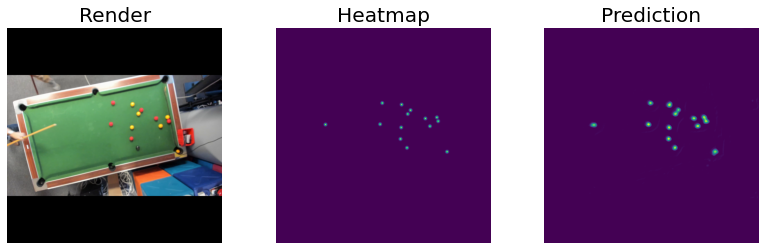

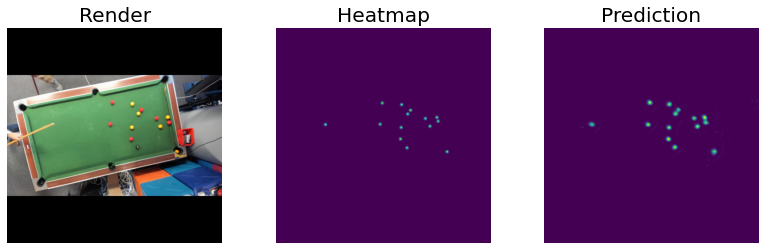

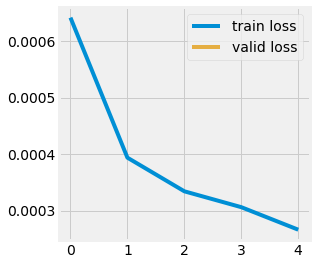

In [7]:
history = []
for epoch in tqdm(range(EPOCHS), desc="Epoch"):
    history.append(step("Train", train_loader, is_train=True))
        
with torch.no_grad():
    step("Test", test_loader, is_train=False)
    plot_example(test)
    
plot_loss_history(history, [])

In [8]:
torch.jit.save(model.cpu(), "models/autoencoder_ood.ts")

## Classifier

In [9]:
EPOCHS = 5

In [10]:
train        = sd.ClDataset("dataset_ood/train/renders", "dataset_ood/train/data")
train_loader = DataLoader(train, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

test         = sd.ClDataset("dataset_ood/test/renders", "dataset_ood/test/data")
test_loader  = DataLoader(test, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

In [11]:
model     = torch.jit.load("models/classifier.ts").cuda()
criterion = nn.CrossEntropyLoss().cuda()
optim     = AdamW(model.parameters())

In [12]:
def plot_example(dataset: sd.ClDataset) -> None:
    for i in range(13):
        window, label = dataset[i]
        logits = torch.softmax(model(window.unsqueeze(0).cuda())[0], dim=0)
        plot_window_probabilities(window, logits)

In [13]:
def step(name: str, loader: DataLoader, dataset: sd.ClDataset, is_train: bool = True) -> Tuple[float, float]:
    global model
    model = model.train() if is_train else model.eval()
    total_loss, total_acc = 0.0, 0.0
    pbar = tqdm(loader, name)
    for window, label in pbar:
        window, label = window.cuda(), label.cuda()
        if is_train:
            optim.zero_grad()
        logits = model(window)
        loss = criterion(logits, label)
        acc = (torch.argmax(logits, dim=1) == label).sum()
        if is_train:
            loss.backward()
            optim.step()
        total_loss += loss.item()
        total_acc += acc.item()
        pbar.set_postfix(loss=total_loss / len(loader), acc=total_acc / len(dataset))
    return total_loss / len(loader), total_acc / len(dataset)

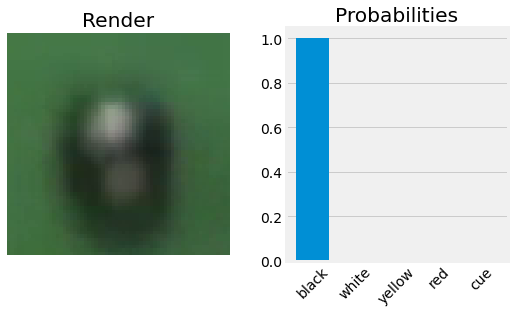

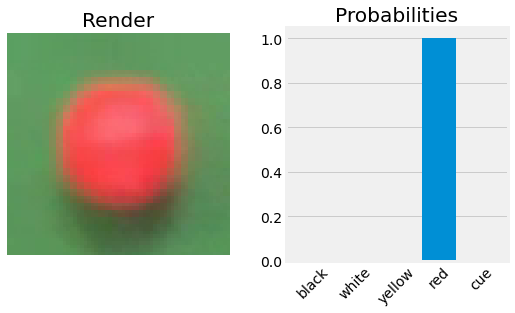

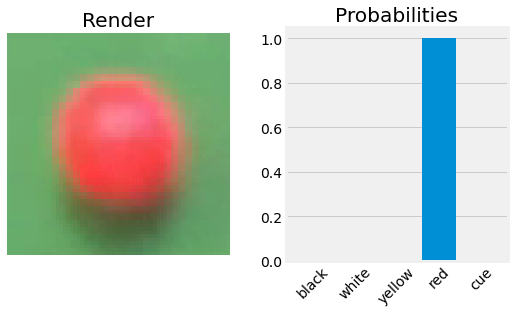

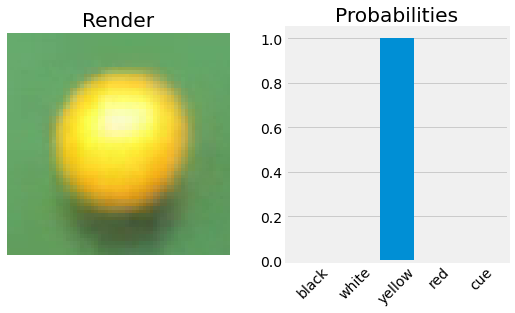

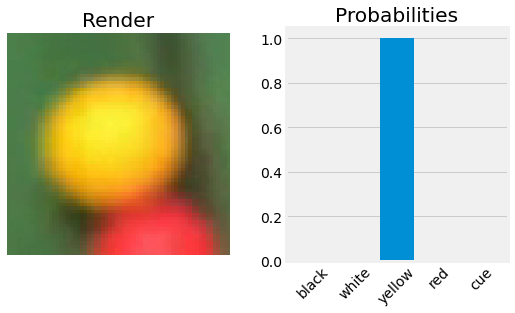

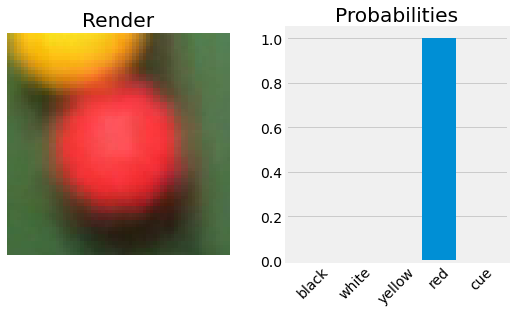

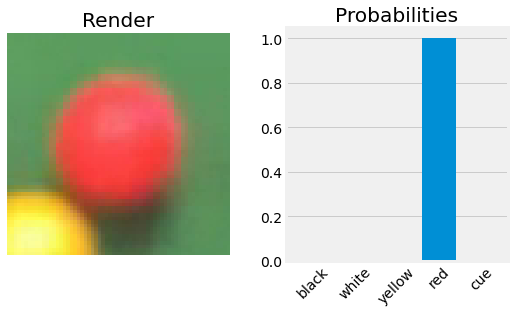

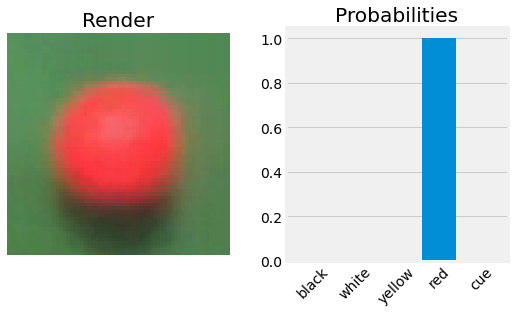

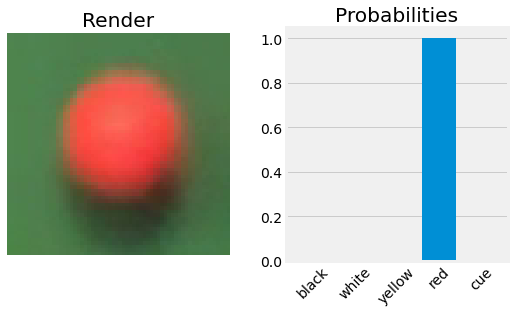

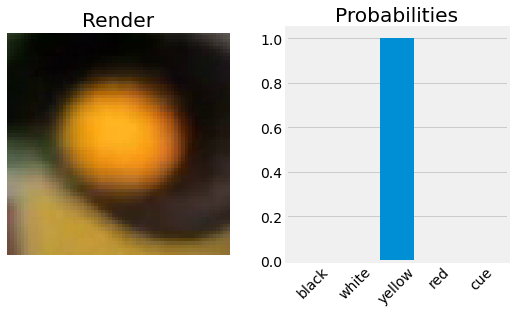

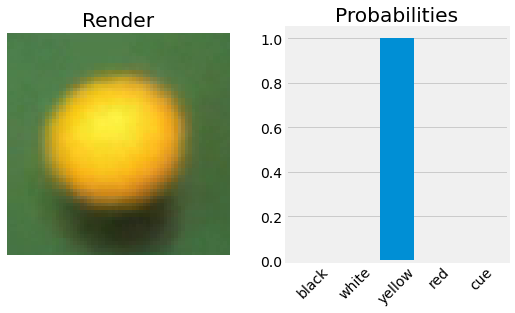

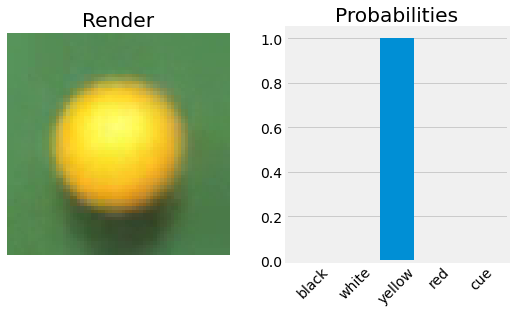

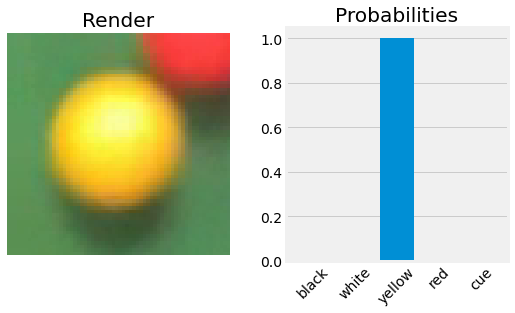

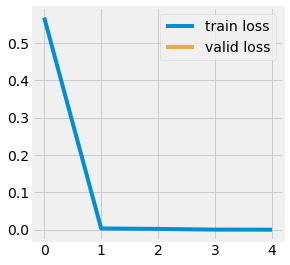

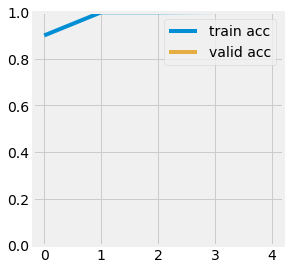

In [14]:
history_loss = []
history_acc  = []
for epoch in tqdm(range(EPOCHS), desc="Epoch"):
    loss, acc = step("Train", train_loader, train, is_train=True)
    history_loss.append(loss)
    history_acc.append(acc)
    
with torch.no_grad():
    loss, acc = step("Test", test_loader, test, is_train=False)
    plot_example(test)
        
plot_loss_history(history_loss, [])
plot_acc_history(history_acc, [])

In [15]:
torch.jit.save(model.cpu(), "models/classifier_ood.ts")

## Final Test

In [16]:
class Snook(nn.Module):
    def __init__(self, autoencoder: str, classifier: str) -> None:
        super(Snook, self).__init__()
        self.autoencoder = torch.jit.load(autoencoder)
        self.classifier  = torch.jit.load(classifier)
        
    def forward(self, x: torch.Tensor, alpha=0.45) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        heatmap = torch.clamp(self.autoencoder(x.unsqueeze(0))[0, 0], 0, 1)
        heatmap[heatmap < alpha] = 0

        peaks = su.peak_detection(heatmap)
        windows = su.peak_windows(render, peaks)

        logits = self.classifier(windows)
        probas = torch.softmax(logits, dim=0)
        labels = torch.argmax(probas, dim=-1)

        return heatmap, peaks, labels
    

snook = Snook("models/autoencoder_ood.ts", "models/classifier_ood.ts").eval().cuda()

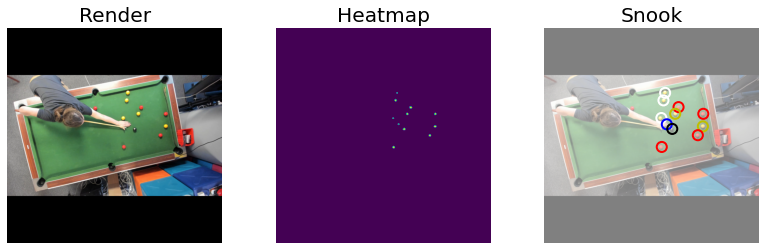

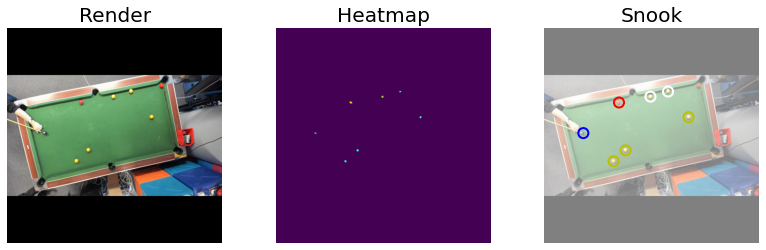

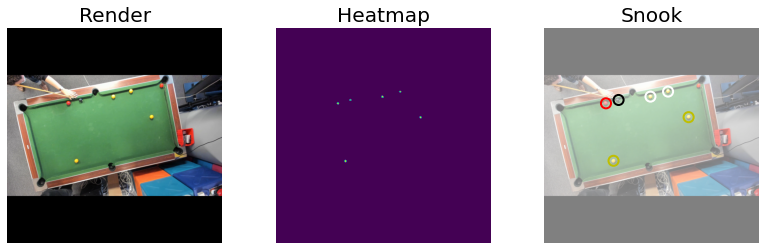

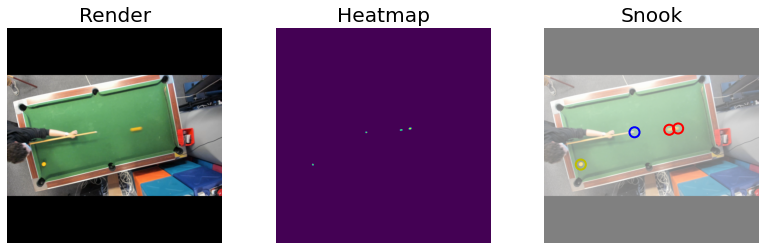

In [17]:
for path in [f"dataset/ood_{i + 1}.png" for i in range(4)]:
    img = np.array(sd.ResizeSquare(512)(Image.open(path).convert("RGB"))) / 255.0
    render = torch.Tensor(img).permute((2, 0, 1))
    render = render.cuda()
    heatmap, peaks, labels = snook(render)
    plot_inference(render, heatmap, peaks, labels)